In [36]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import scienceplots as scp

import numpy as np
import torch

matplotlib.rcParams['figure.figsize'] = (20, 6)

from main import main, parse_args

from argparse import Namespace
from utils.plotting import plot_change_responses, plot_trial_responses, plot_omission_responses, plot_sequence_response
from utils.analysis import process_outputs, get_change_responses, get_omission_responses

import os

import warnings
warnings.filterwarnings('ignore')

SCRATCH = "/storage/ice1/7/2/asharafeldin3/novelty_encoding_model"

In [37]:
import importlib 
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_change_responses, plot_trial_responses, plot_omission_responses, plot_sequence_response, plot_training_progress, plot_dprimes, plot_example_reward_sequence

In [38]:
def load_results_files(directory, prefix):
    # Ensure directory exists
    if not os.path.isdir(directory):
        print(f"Error: {directory} is not a valid directory.")
        return {}

    # Get list of files in directory
    files = os.listdir(directory)
    # Filter files by prefix and ending with '.pt'
    torch_files = [file for file in files if file.startswith(prefix)]

    args = None

    change_responses = {"familiar": {}, "novel": {}}
    omission_responses = {"familiar": {}, "novel": {}}
    training_progress = {}
    for i, file in enumerate(torch_files):
        file_path = os.path.join(directory, file)
        try:
            # Load Torch file
            data = torch.load(file_path, map_location='cpu')
            # Concatenate tensors along the first axis

            if args is None:
                args = data['args']

            # first for change responses
            for key in data["change_responses"]["familiar"].keys():
                fam_value = data["change_responses"]["familiar"][key]
                nov_value = data["change_responses"]["novel"][key]
                if key not in change_responses["familiar"]:
                    change_responses["familiar"][key] = fam_value
                    change_responses["novel"][key] = nov_value
                else:
                    change_responses["familiar"][key] = torch.cat([change_responses["familiar"][key], fam_value])
                    change_responses["novel"][key] = torch.cat([change_responses["novel"][key], nov_value])
            
            # now for omission responses
            for key in data["omission_responses"]["familiar"].keys():
                fam_value = data["omission_responses"]["familiar"][key]
                nov_value = data["omission_responses"]["novel"][key]
                if key not in omission_responses["familiar"]:
                    omission_responses["familiar"][key] = fam_value
                    omission_responses["novel"][key] = nov_value
                else:
                    omission_responses["familiar"][key] = torch.cat([omission_responses["familiar"][key], fam_value])
                    omission_responses["novel"][key] = torch.cat([omission_responses["novel"][key], nov_value])
            
            # finally training progress
            for key in data['training_progress'].keys():
                if key not in training_progress:
                    training_progress[key] = [data['training_progress'][key]]
                else:
                    training_progress[key] += [data['training_progress'][key]]

            print(f"Loaded {i + 1}/{len(torch_files)} files", end='\r')
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
    
    training_progress = {k: np.stack(v) for k, v in training_progress.items()}
    
    return args, change_responses, omission_responses, training_progress

### Perception only

In [39]:
passive_args, passive_change, passive_omission, passive_progress = load_results_files(f"{SCRATCH}/results/experimental", "no_energy")
passive_args = Namespace(**passive_args)

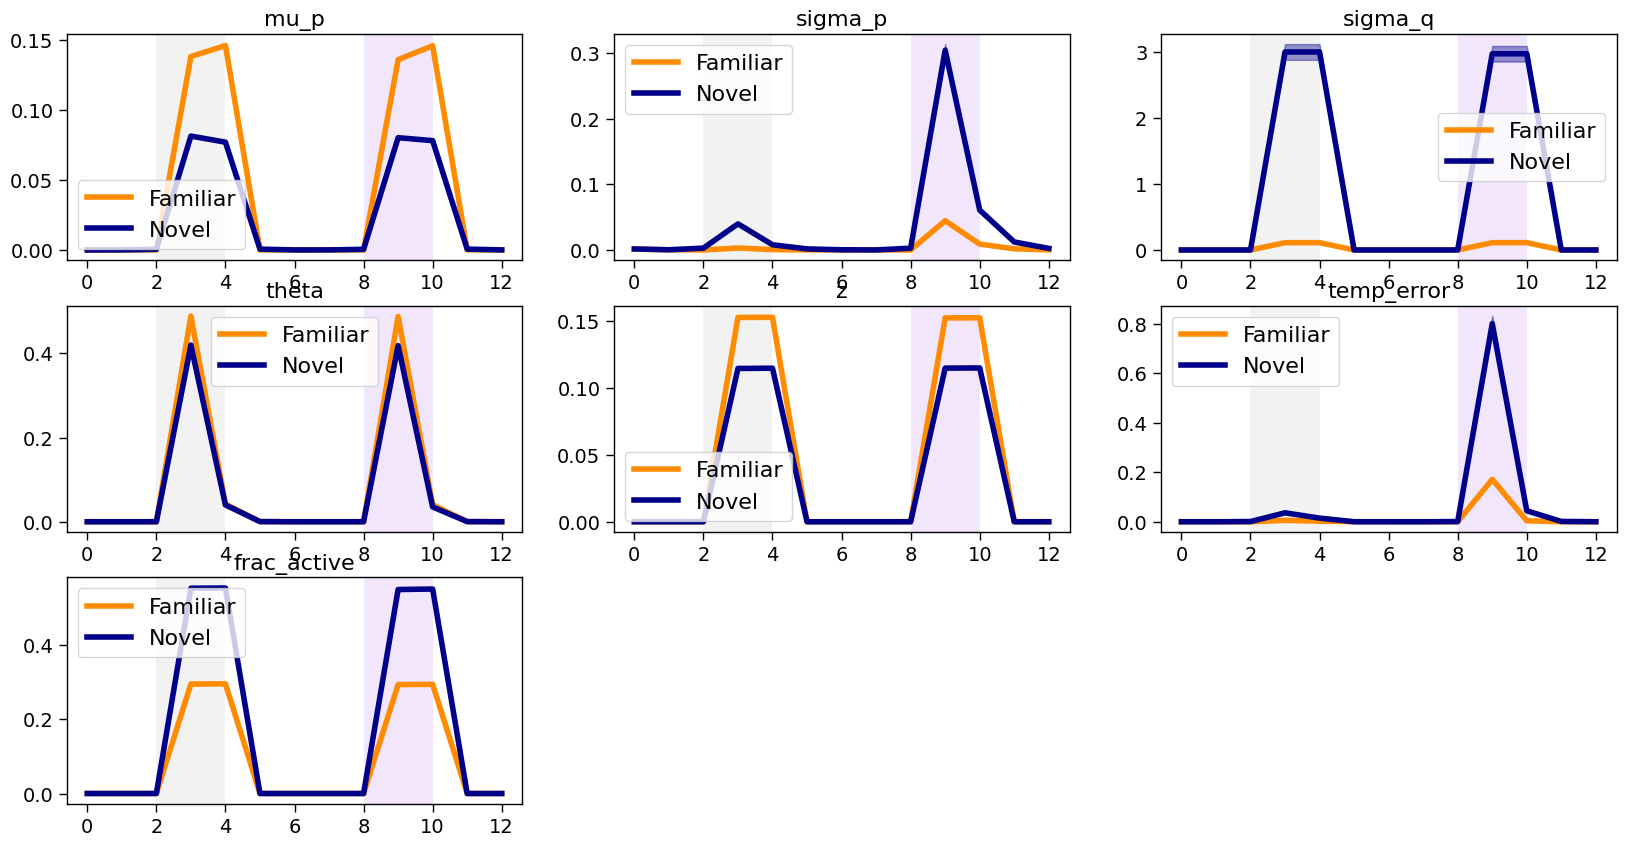

In [40]:
##### plot responses around image change

with plt.style.context(['nature', 'notebook']):
        
    passive_change_fig = plt.figure(figsize=(20, 10))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(passive_change['familiar'].keys()):
        ax = plt.subplot(3, 3, i+1)
        plot_trial_responses(passive_args, ax, passive_change['familiar'][pop], passive_change['novel'][pop], normalize=False)
        ax.set_title(f"{pop}")
        ax.legend()

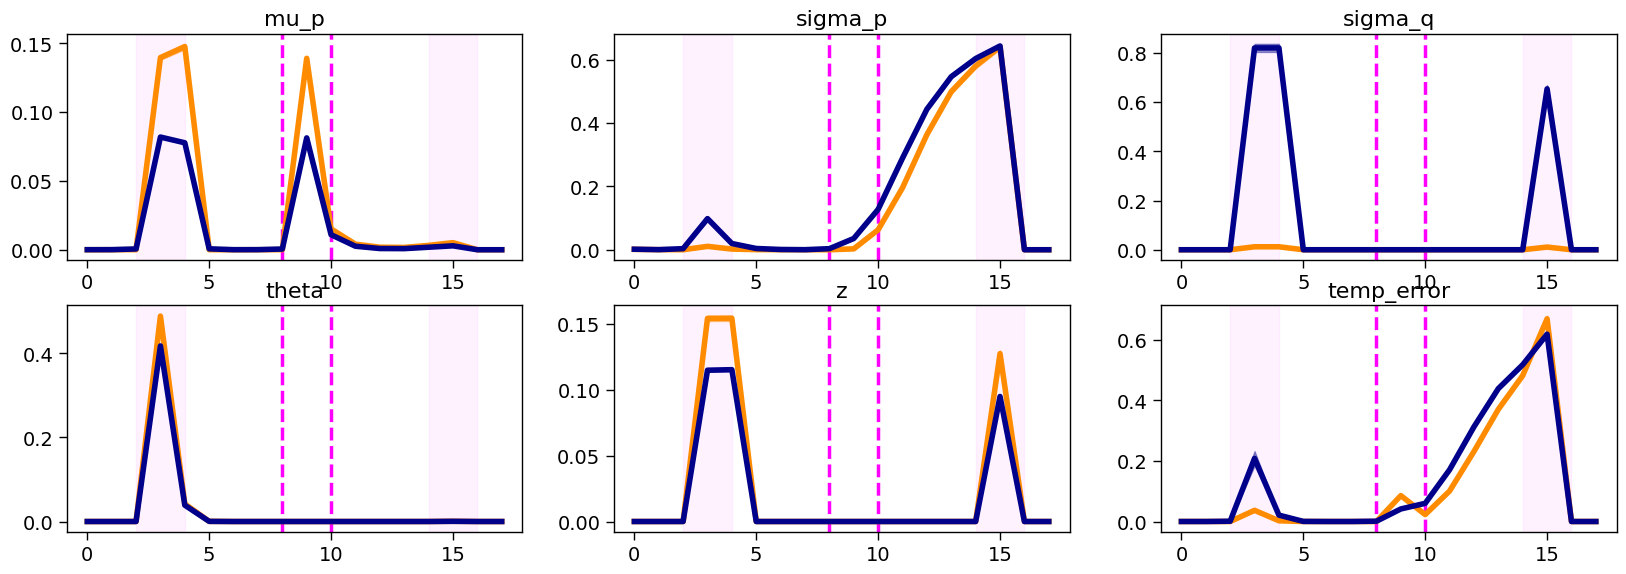

In [41]:
##### plot responses around omissions

with plt.style.context(['nature', 'notebook']):
    
    passive_omission_fig = plt.figure(figsize=(20, 10))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(passive_omission['familiar'].keys()):
        ax = plt.subplot(3, 3, i+1)
        plot_trial_responses(passive_args, ax, passive_omission['familiar'][pop], passive_omission['novel'][pop], trial_mode='omission', normalize=False)
        _ = ax.set_title(f"{pop}")

### Perception with Action

In [42]:
active_args, active_change, active_omission, active_progress = load_results_files(f"{SCRATCH}/results/experimental", "perception_action")
active_args = Namespace(**active_args)

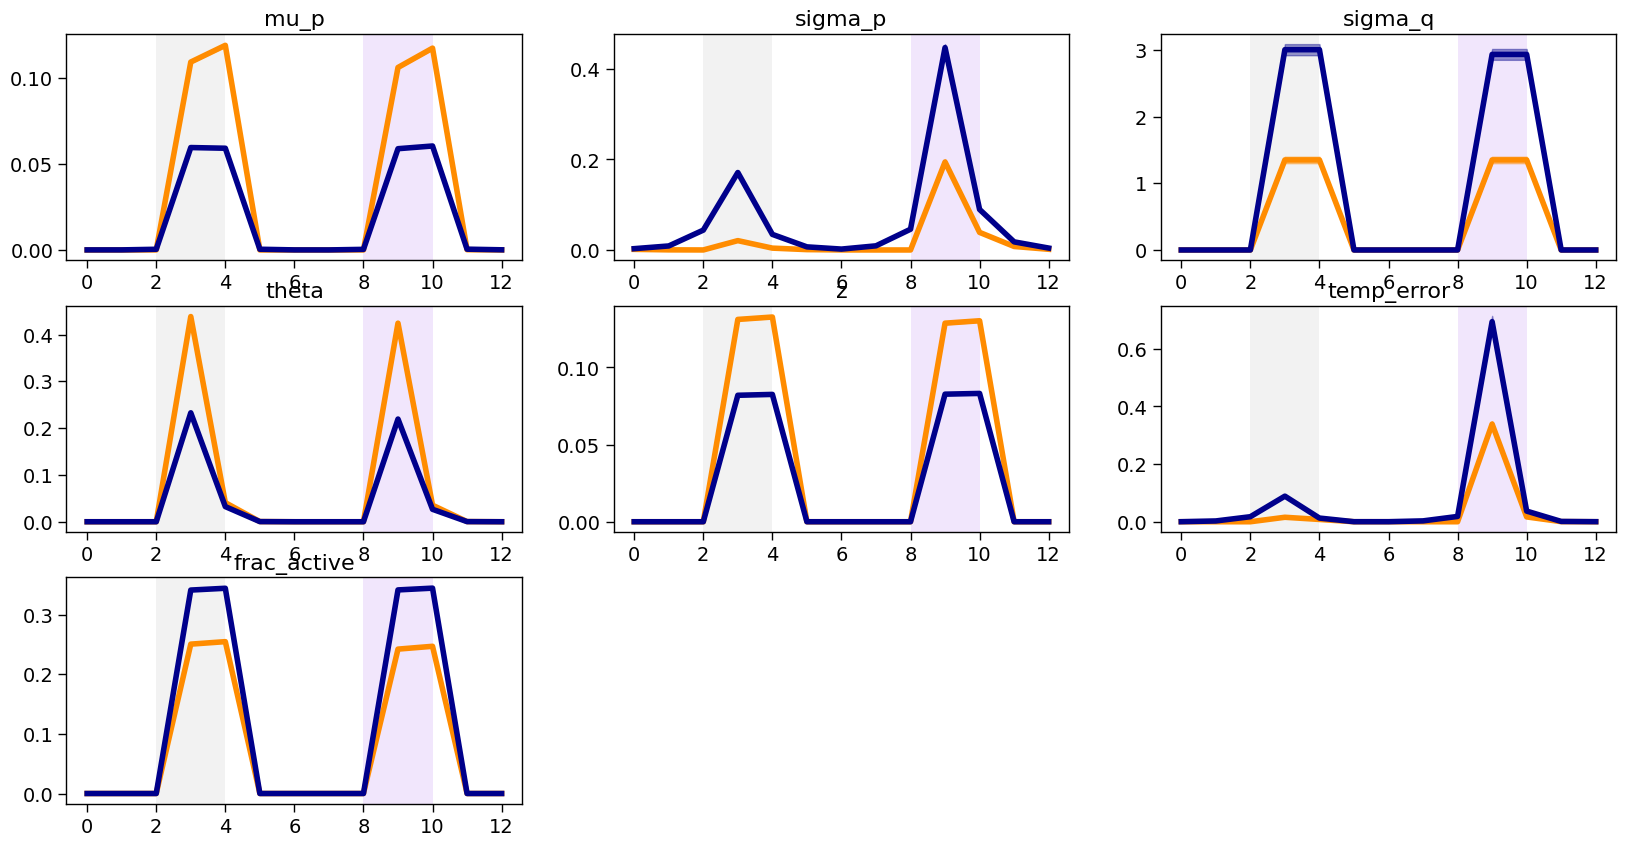

In [43]:
##### plot responses around image change

with plt.style.context(['nature', 'notebook']):
        
    active_change_fig = plt.figure(figsize=(20, 10))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(active_change['familiar'].keys()):
        ax = plt.subplot(3, 3, i+1)
        plot_trial_responses(active_args, ax, active_change['familiar'][pop], active_change['novel'][pop], normalize=False)
        ax.set_title(f"{pop}")
        #ax.legend()

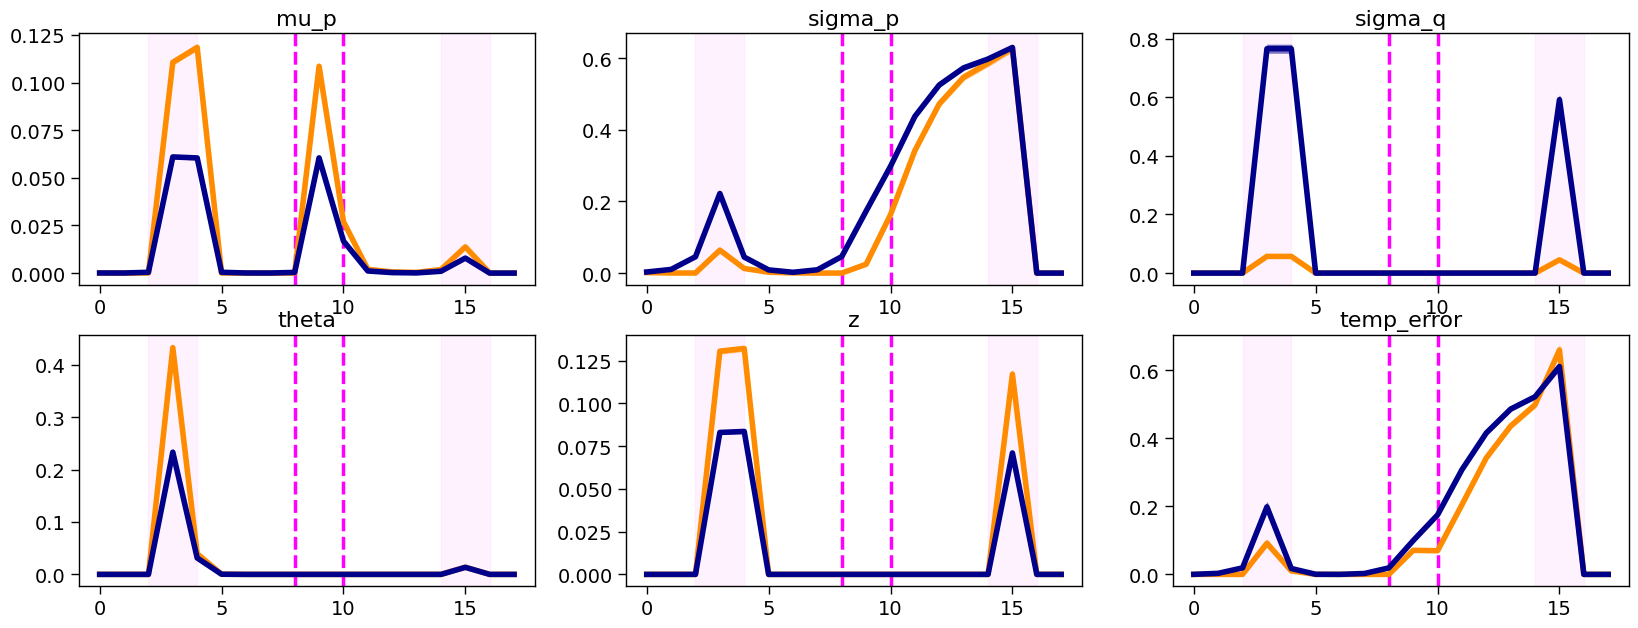

In [44]:
##### plot responses around omissions

with plt.style.context(['nature', 'notebook']):

    active_omission_fig = plt.figure(figsize=(20, 15))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(active_omission['familiar'].keys()):
        ax = plt.subplot(4, 3, i+1)
        plot_trial_responses(active_args, ax, active_omission['familiar'][pop], active_omission['novel'][pop], trial_mode='omission', normalize=False)
        _ = ax.set_title(f"{pop}")

(0.0, 0.5)

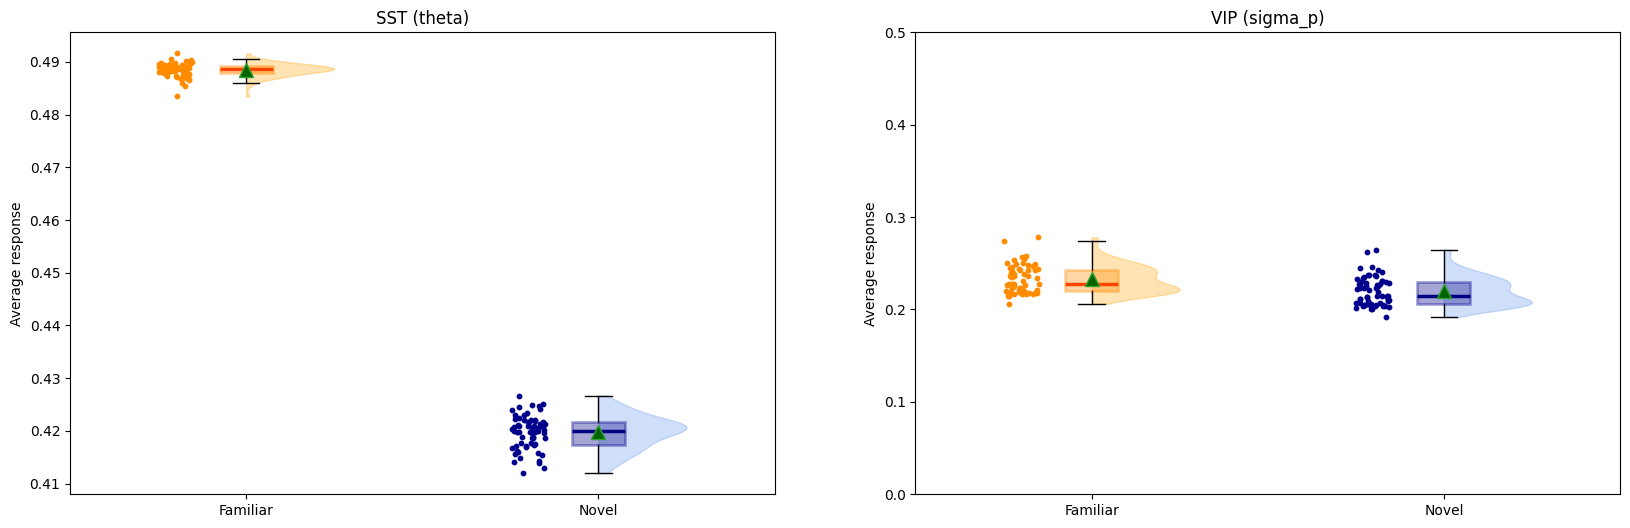

In [45]:
from utils.plotting import raincloud_plot

sq = 3

exp_ax1 = plt.subplot(1, 2, 1)
famt = passive_change['familiar']['theta'][:, 3].detach()
novt = passive_change['novel']['theta'][:, 3].detach()
nonlin = lambda x: x.mean(0) #torch.relu(x - .95).mean(0) #(1 - 0.1 * x).mean(-1) 
raincloud_plot(exp_ax1, nonlin(famt), nonlin(novt))
plt.title('SST (theta)')
#plt.ylim([0., 0.7])

exp_ax2 = plt.subplot(1, 2, 2)
fams = active_change['novel']['theta'][:, 3].detach()
novs = active_change['novel']['theta'][:, 9].detach()
raincloud_plot(exp_ax2, torch.mean(fams, dim=0), torch.mean(novs, dim=0))
plt.title('VIP (sigma_p)')
plt.ylim([0., 0.5])

### Confidence interval plots

Text(0.5, 1.0, 'VIP (sigma_p)')

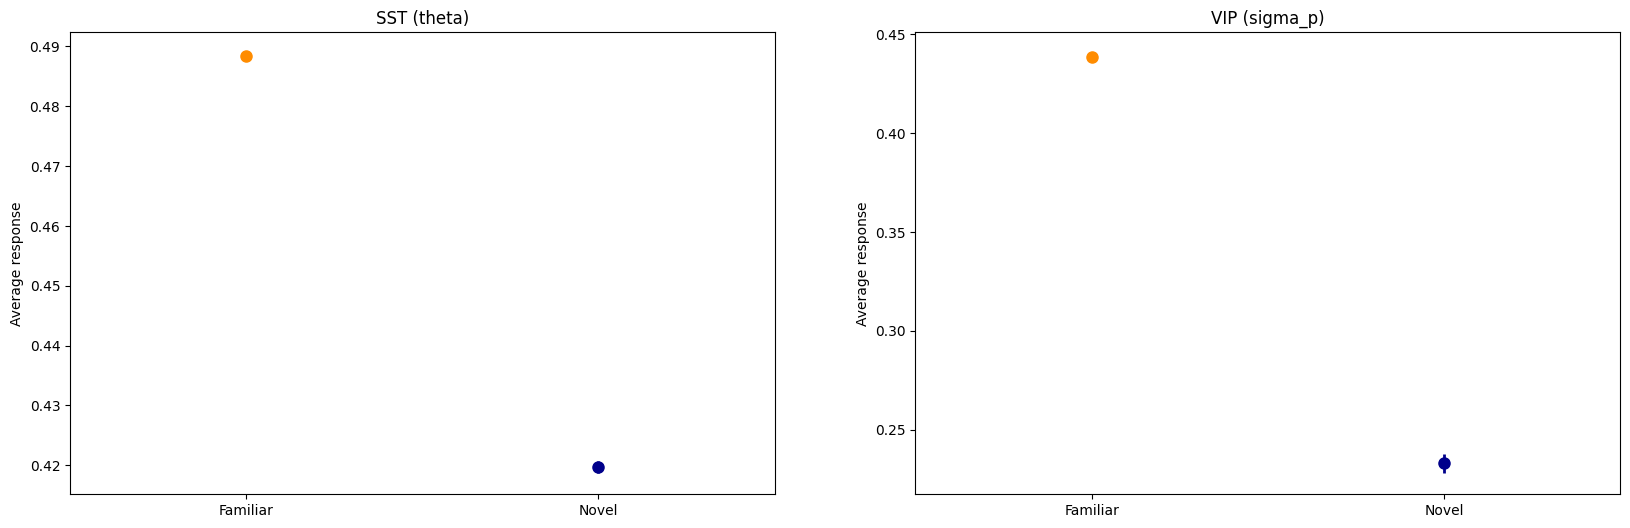

In [46]:
from utils.plotting import plot_confidence_intervals

exp_ax1 = plt.subplot(1, 2, 1)
famt = passive_change['familiar']['theta'][:, 3].detach()
novt = passive_change['novel']['theta'][:, 3].detach()
nonlin = lambda x: x.mean(0)
plot_confidence_intervals(exp_ax1, nonlin(famt).numpy(), nonlin(novt).numpy(), alpha=0.01)
plt.title('SST (theta)')
#plt.ylim([0., 0.25])

exp_ax2 = plt.subplot(1, 2, 2)
fams = active_change['familiar']['theta'][:, 3].detach()
novs = active_change['novel']['theta'][:, 3].detach()
plot_confidence_intervals(exp_ax2, fams.mean(0).numpy(), novs.mean(0).numpy(), alpha=0.01)
plt.title('VIP (sigma_p)')
#plt.ylim([0., 0.25])



### Training progress

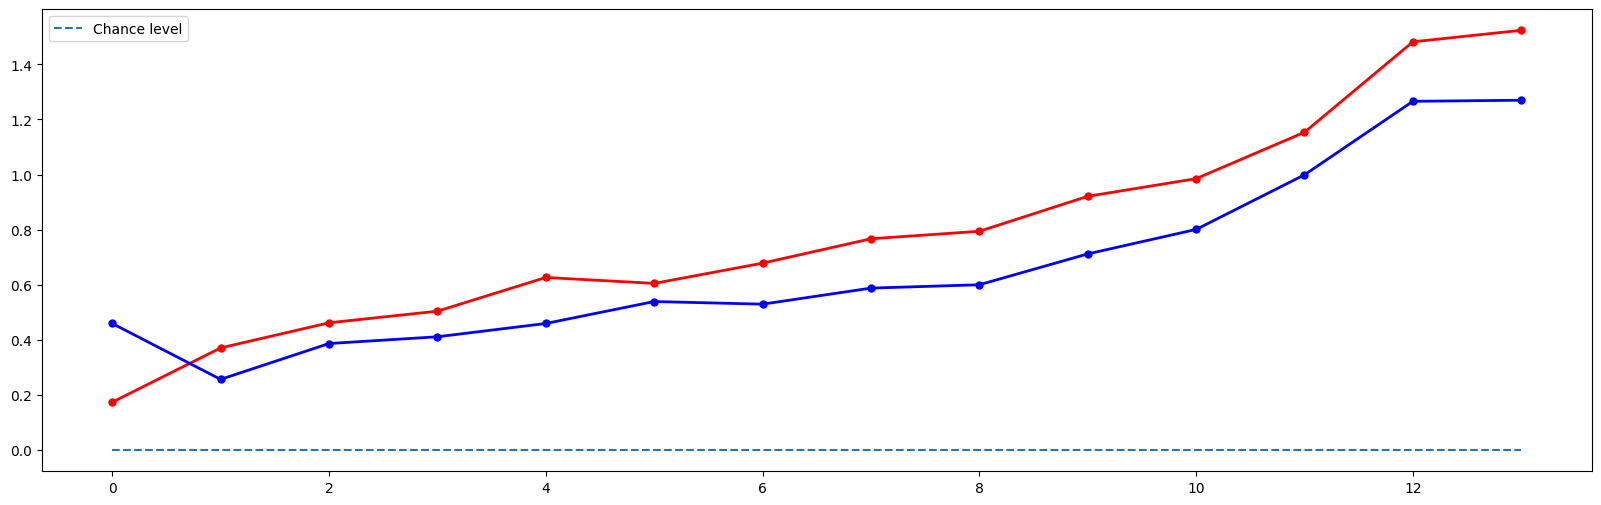

In [47]:
dprime = active_progress['dprime'].mean(0)
dprime_novel = active_progress['dprime_novel'].mean(0)
plt.plot(dprime, '-or', linewidth=2.0, markersize=5)
plt.plot(dprime_novel, '-ob', linewidth=2.0, markersize=5)
plt.plot()
plt.plot(np.arange(len(dprime)), np.zeros_like(dprime), '--', label='Chance level')
plt.legend()

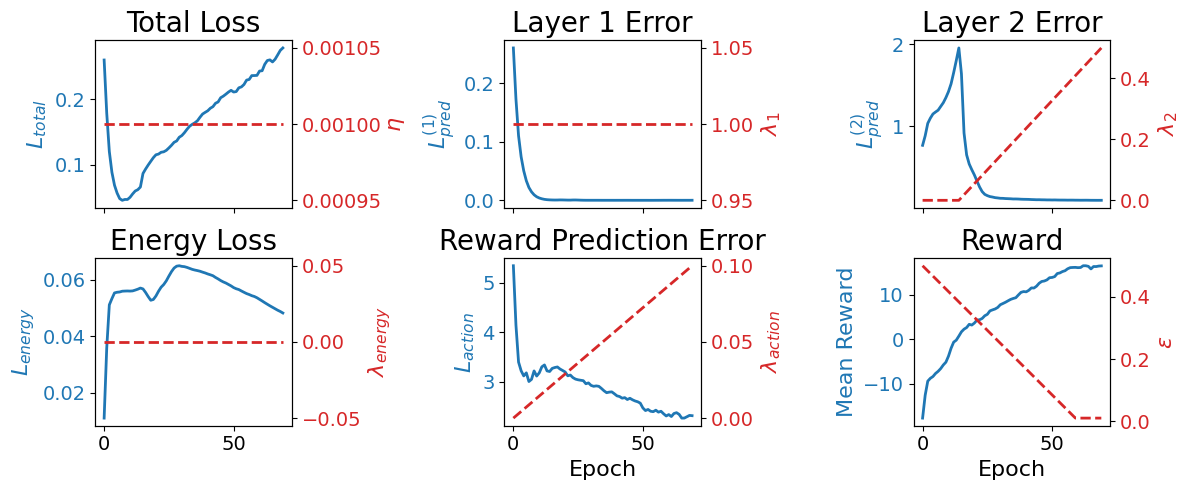

In [48]:
_ = plot_training_progress(passive_args, passive_progress, save_fig=False)

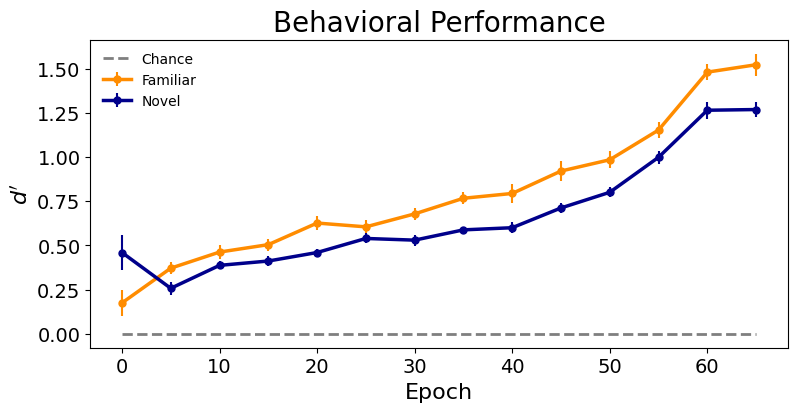

In [49]:
dprimes_fig, dprimes_ax = plt.subplots(1, 1, figsize=(9, 4))
plot_dprimes(dprimes_ax, np.arange(active_args.num_epochs, step=5.),
             active_progress['dprime'],
             active_progress['dprime_novel'],
             title="Behavioral Performance", xlabel='Epoch')

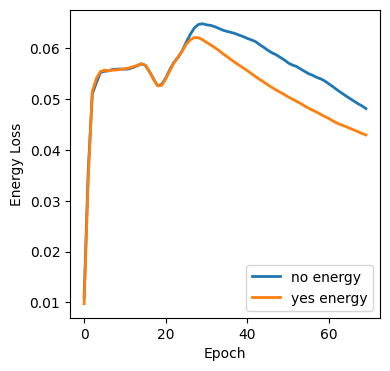

In [50]:
plt.figure(figsize=(4, 4))

plt.plot(passive_progress['energy'].mean(0), linewidth=2., label='no energy')
plt.plot(active_progress['energy'].mean(0), linewidth=2., label='yes energy')
plt.xlabel('Epoch')
plt.ylabel('Energy Loss')
plt.legend()

(0.0, 0.5)

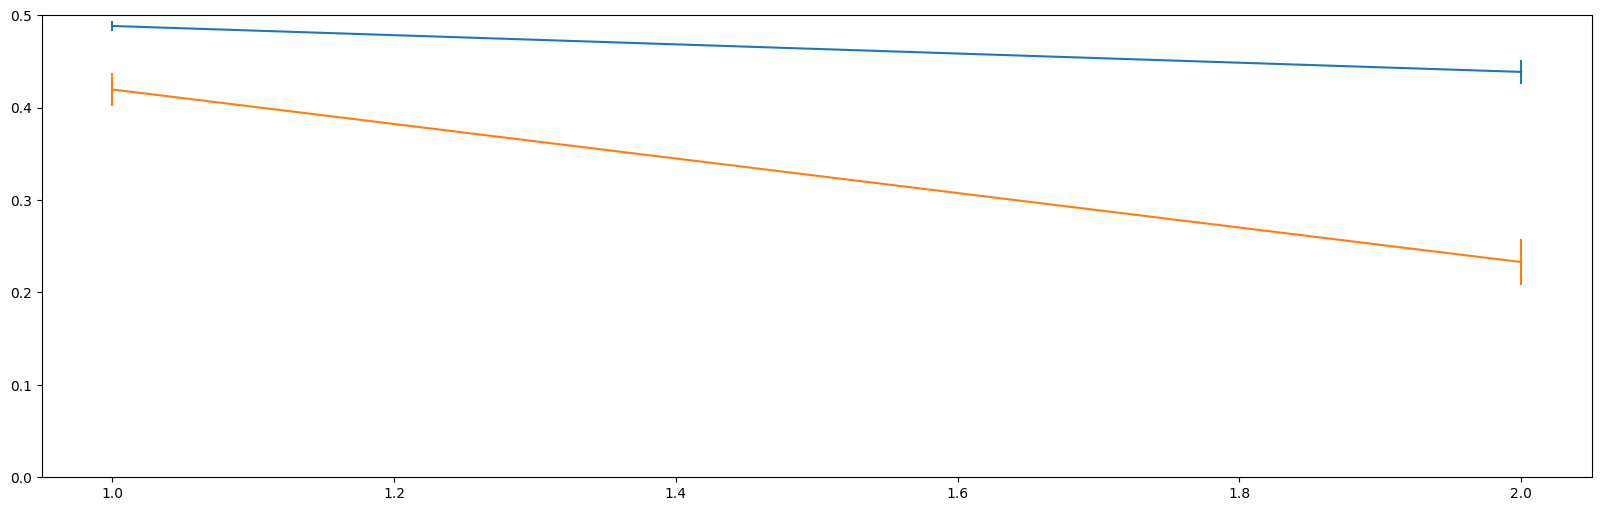

In [51]:
passive = [passive_change['familiar']['theta'][:, 3].mean().detach(), active_change['familiar']['theta'][:, 3].mean().detach()]
active = [passive_change['novel']['theta'][:, 3].mean().detach(), active_change['novel']['theta'][:, 3].mean().detach()]

pstd = [passive_change['familiar']['theta'][:, 3].std().detach(), active_change['familiar']['theta'][:, 3].std().detach()]
astd = [passive_change['novel']['theta'][:, 3].std().detach(), active_change['novel']['theta'][:, 3].std().detach()]

n = (passive_change['familiar']['theta'][:, 3].shape[0] * passive_change['familiar']['theta'][:, 3].shape[-1])**0.5

plt.errorbar([1, 2], passive, np.array(pstd)/8)
plt.errorbar([1, 2], active, np.array(astd)/8)

plt.ylim([0, 0.5])